# The what and where of metal genres: Scraping the [Metal Archives](http://www.metal-archives.com)

The internet lets people share music from all over the world. I know a lot of the metal I listen to is made by bands from many different countries. I can think of metal bands I love from Sweden, France, Germany, Italy, Canada, Brazil, the UK, and Norway just off the top of my head. While specific genres often grow out of a certain regional scene, there is no absolute rule that confines genres geographically. For instance, you don't have to be from Norway to start a black metal.

I've often wondered *where metal is popular in the world* or *if certain genres are more popular in different countries*. These questions may be easy to answer if you're a company like Amazon or Spotify and have access to things like sales and listening data. Alas, I do not have access to either of those, but luckily the [Metal Archives](http://www.metal-archives.com) (M-A) exists. It is a magnificient compendium of user-contributed information on metal bands.

So I decided to write a simple scraper using [requests](http://docs.python-requests.org/en/master/) and [pandas](http://pandas.pydata.org/) to compile a simple data set capable of answering my buring questions about metal genres. You find the script in my [ma-scraper repo](http://github.com/jonchar/ma-scraper/).

Who wouldn't want to answer questions about their favorite musical genre with data?

## Obtaining the data

This data can be obtained using the script `MA_scraper.py`. This scrapes M-A for a listing of band names alphabetically (as seen [here](http://www.metal-archives.com/lists/A) for example). The site uses AJAX to retrieve band names and display them in the page. It does so in chunks of 500 bands. From inspecting the page source it was easy to guess the location and naming of the URLs from which the band names are retrieved. Towards the bottom of the page source, you can find this line of JavaScript which generates the table of band names:

     var grid = createGrid("#bandListAlpha", 500, 'browse/ajax-letter/l/A/json/1', ... );
     
This line uses data retrieved from `www.metal-archives.com/`**`browse/ajax-letter/l/A/json/1`**`/{A-Z}` to generate the grid of links displayed on the page. The link indicates that the data is probably returned in JSON format to the browser when generating the grid. This turns out to be the case and is what is assumed in `MA_scraper.py`.

The output data is stored as a CSV file with the name `MA-band-names_YYYY-MM-DD.csv`.

## About the data

The data scraped includes each band's name (with a link to the band's M-A page), country of origin, genre, and status (active, split-up, changed name, on hold, unknown, or disputed). The data was scraped on 2016-03-14 at around 10PM and consists of 107,015 bands.

As far as I know, the Metal Archives is the largest compendium of data on metal bands and I believe it is all user-contributed. That said, a huge thank you to the maintainers of the Metal Archives and all of the users who have contributed information to the site!

## Specific Questions

There are countless questions we could ask of this data set, but we're going to focus on a few in particular:

<!-- ### Potential questions 

* Which countries do most metal bands hail from?
* What genres are popular in each country?
* Which genres currently have the most active bands?
* What are the most popular words that make up metal band names?
-->

* Which countries have the most active metal bands? Most inactive?
* What genres are most popular? Least popular?
* What are the most popular genres in the countries with the most active bands?

While these may not seem too pressing, they gave me an excuse to do some web scraping and learn more about my favorite type of music. In the future I hope to dig further and scrape the site a bit more for things like releases, band member timelines / overlap, lyrics, reviews, etc.

Enough already, on to the code!

In [56]:
import string
import re
import itertools
import requests
from bs4 import BeautifulSoup
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set_style('whitegrid')
from wordcloud import WordCloud, ImageColorGenerator
import networkx as nx
import functools
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

Read in raw scraped data

In [2]:
data = pd.read_csv('MA-band-names_2016-04-01.csv', index_col=0) # Change the date if using data you scraped

In [3]:
data.head()

,NameLink,Country,Genre,Status
0,<a href='http://www.metal-archives.com/bands/0...,Finland,Doom Metal,"<span class=""split_up"">Split-up</span>"
1,<a href='http://www.metal-archives.com/bands/0...,Greece,Death/Thrash Metal,"<span class=""active"">Active</span>"
2,<a href='http://www.metal-archives.com/bands/0...,Slovakia,Industrial Experimental Metal,"<span class=""active"">Active</span>"
3,<a href='http://www.metal-archives.com/bands/1...,Australia,Death Metal/Groove Metal,"<span class=""active"">Active</span>"
4,<a href='http://www.metal-archives.com/bands/1...,United States,Thrash/Heavy Metal,"<span class=""changed_name"">Changed name</span>"


## Cleaning up the data

We have a little bit of cleaning up to do:

1. The `NameLink` column contains the band name and it's respective M-A link. we should pull out the link and band name and put them into their own columns for easy reference later on.
2. The `Status` column has some styling information that isn't necessarily useful to us so if we can pull out just the text that would be better.
3. The `Genre` column contains a string descriptor of the band's genre, which I'm not sure is standardized. Tokenizing these strings somehow would help us in quantifying which terms occur most often.

### Processing band names

Here we'll make use of the `map` method of the `pd.Series` class to achieve what we want. First the `NameLink` column. We'll use BeautifulSoup to parse the HTML contained within, then use the results to construct the columns we desire (one column with the band name and another with it's corresponding M-A link).

In [4]:
data['NameSoup'] = data['NameLink'].map(lambda raw_html: BeautifulSoup(raw_html, 'html.parser'))
data['BandName'] = data['NameSoup'].map(lambda soup: soup.text)      # extracts band name
data['BandLink'] = data['NameSoup'].map(lambda soup: soup.a['href']) # extracts link to band's page on M-A

### Processing band status

Next we'll take a similar approach for extracting each band's status. Here we end up *replacing* the original `Status` column.

In [5]:
data['StatusSoup'] = data['Status'].map(lambda raw_html: BeautifulSoup(raw_html, 'html.parser'))
data['Status'] = data['StatusSoup'].map(lambda soup: soup.text)

Now let's check to see that our mappings worked and the columns `BandName`, `BandLink`, and `Status` have the correctly formatted information.

In [6]:
data[['BandName', 'BandLink', 'Status']].head()

,BandName,BandLink,Status
0,0 X í S T,http://www.metal-archives.com/bands/0_X_%C3%AD...,Split-up
1,0 Zone,http://www.metal-archives.com/bands/0_Zone/354...,Active
2,0N0,http://www.metal-archives.com/bands/0N0/354032...,Active
3,1 Shot Kill,http://www.metal-archives.com/bands/1_Shot_Kil...,Active
4,10 Kingdoms,http://www.metal-archives.com/bands/10_Kingdom...,Changed name


### Processing band genre data

Here we'll tokenize the string in the `Genre` column to obtain a list of terms. This should help us in identifying all of the keywords used to describe bands in terms of genre. To do this, we'll replace all punctuation with spaces and then split the strings on spaces to get our list of terms.

In [7]:
def replace_punctuation(raw, replacement=' '):
    """Replaces all punctuation in the input string `raw` with a space.
    Returns the new string."""
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    output = regex.sub(replacement, raw)
    return output

def split_terms(raw):
    """Splits the terms in the input string `raw` on all spaces and punctuation.
    Returns a list of the terms in the string."""
    replaced = replace_punctuation(raw, replacement=' ')
    output = tuple(replaced.split())
    return output

Now we can split the strings in the `Genre` column into separte terms with a simple map.

In [8]:
data['GenreTerms'] = data['Genre'].str.replace('Metal', '').map(split_terms)

#### Finding the top genre terms

Now that we have the genre descriptors tokenized, we'll compile a list of unique terms. This will make it easier to do some quantification later on. To do this we'll first flatten the column `GenreTerms` into a list, then use the `np.unique()` function to get the unique terms and their corresponding counts.

In [9]:
all_terms = list(itertools.chain.from_iterable(data['GenreTerms']))      # Flatten terms to list
unique_terms, counts = np.unique(all_terms, return_counts=True)          # Get unique terms & counts
genre_terms = pd.DataFrame({'Term': unique_terms, 'TotalCount': counts}) # Store in DataFrame
genre_terms.sort_values('TotalCount', ascending=False, inplace=True)     # Sort by count

### Feature vector construction

Create binarized feature matrix (n_bands x unique_terms)

In [25]:
mlb = MultiLabelBinarizer()
mlb.fit([[x] for x in [term for term in unique_terms]])
binarized_terms = mlb.transform(data['GenreTerms'].values[:2000]).astype('int8')

It seems we can't compute this for all data points at once (numpy memory error), hence using `int8`. Maybe we need a swapfile?

In [26]:
binarized_terms.dtype

dtype('int8')

### MDS

In [45]:
mds = MDS()
mds_coords = mds.fit_transform(binarized_terms)

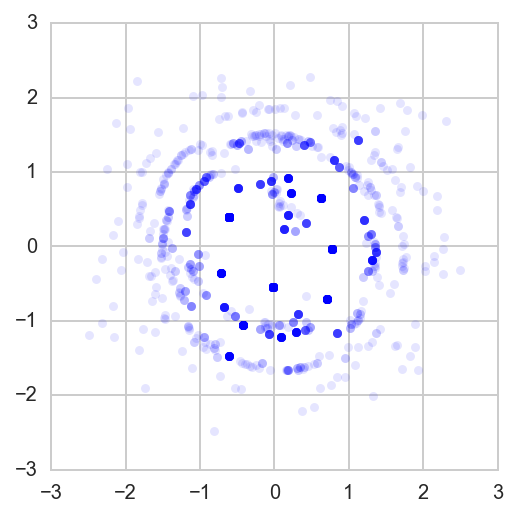

In [166]:
fig, ax = plt.subplots(figsize=(4,4))

ax.scatter(mds_coords[:,0], mds_coords[:,1], lw=0, alpha=0.1)

### PCA

In [47]:
pca = PCA()
components = pca.fit_transform(binarized_terms)

Components 1 and 2

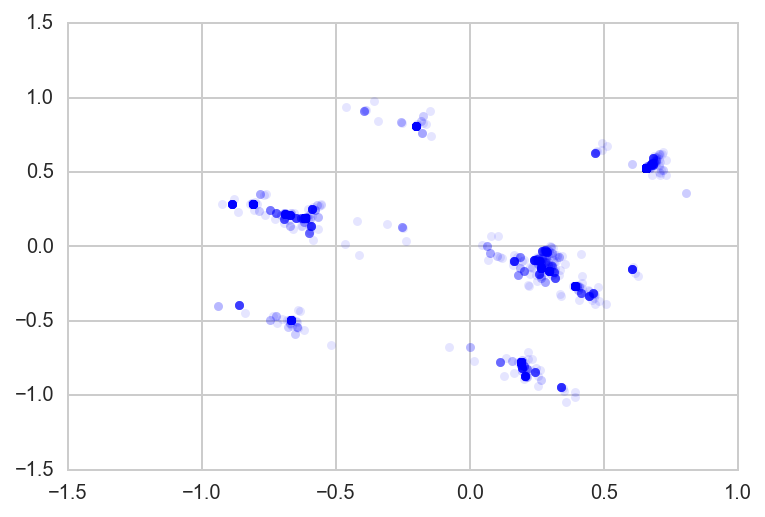

In [174]:
fig, ax = plt.subplots()

ax.scatter(components[:,0], components[:,1], alpha=0.1, lw=0)

Components 2 and 3

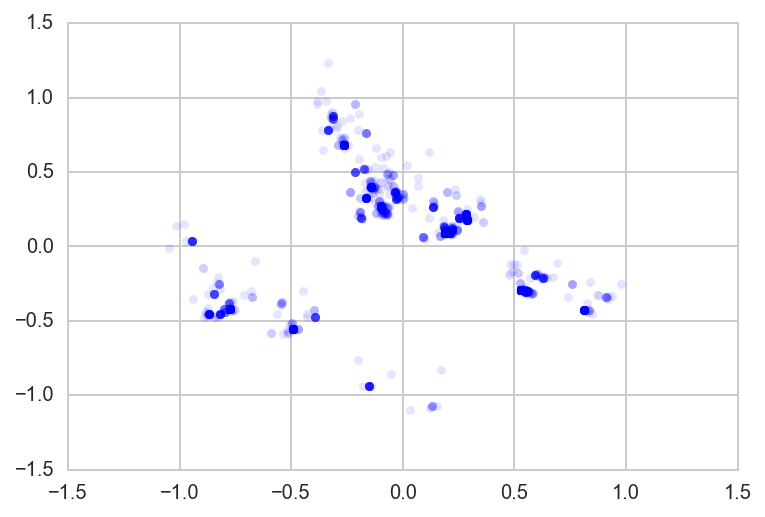

In [175]:
fig, ax = plt.subplots()
ax.scatter(components[:,1], components[:,2], alpha=0.1, lw=0)

Components 1 and 3

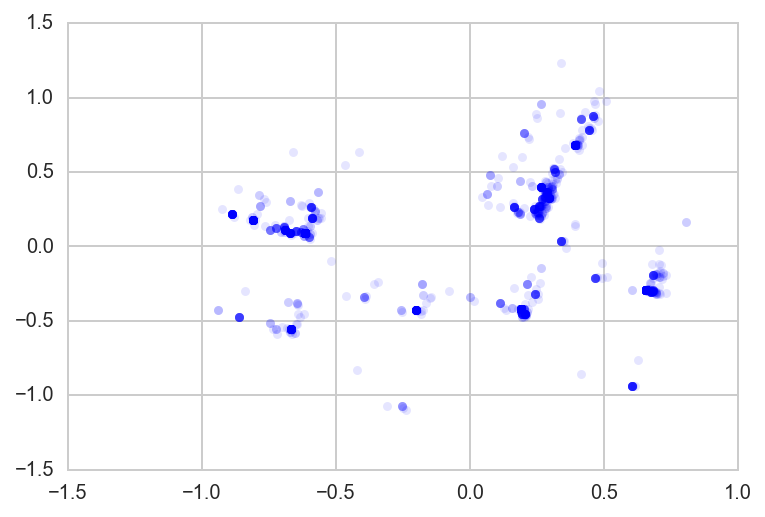

In [176]:
fig, ax = plt.subplots()
ax.scatter(components[:,0], components[:,2], alpha=0.1, lw=0)

### $k$-means

Use PCA components 1 and 2

In [178]:
kmeans = KMeans(n_clusters=6)
clusters = kmeans.fit_predict(components[:,[0,1]])

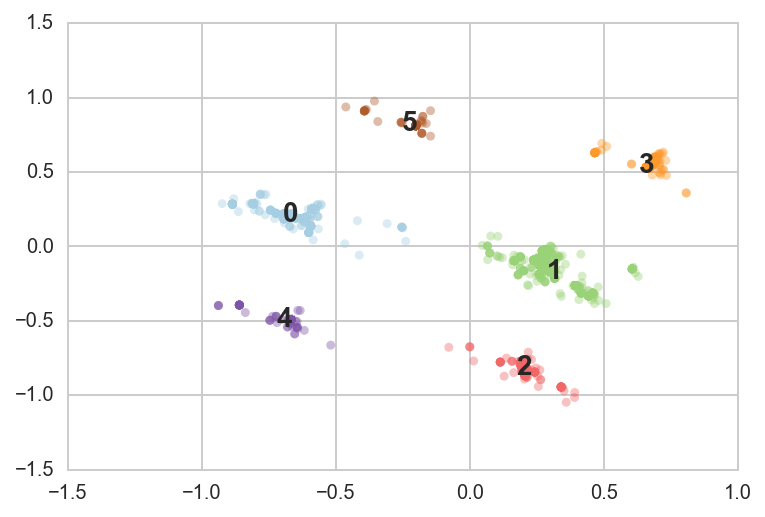

In [179]:
fig, ax = plt.subplots()
ax.scatter(components[:,0], components[:,1], alpha=0.4, lw=0, color=plt.cm.Paired(clusters/5))
for i, center in enumerate(kmeans.cluster_centers_):
    ax.text(center[0], center[1], '%d' % i, fontsize=14, weight='bold', ha='center', va='center')

Do the clusters correspond to particular sub-genres?

In [188]:
subset = data['GenreTerms'].values[:2000]

centroids = np.arange(6)

for centroid in centroids:
    print('Centroid %d:' % centroid)
    # pull out genre terms, concatenate
    cluster_term_sets = subset[clusters == centroid]
    cluster_terms = np.fromiter(itertools.chain.from_iterable(cluster_term_sets), dtype='<U13')
    terms, counts = np.unique(cluster_terms, return_counts=True)
    df = pd.DataFrame({'top terms': terms, 'counts': counts})
    df.sort_values('counts', ascending=False, inplace=True)
    print(df.head(5))

Centroid 0:
    counts  top terms
10     554      Death
27     124    Melodic
7       58     Brutal
40      55       core
19      43  Grindcore
Centroid 1:
    counts    top terms
27     195        Heavy
40     109  Progressive
12      80         Doom
38      76        Power
43      64         Rock
Centroid 2:
    counts  top terms
26     274     Thrash
10      40     Groove
4       21  Crossover
13      20      Heavy
17      18      Power
Centroid 3:
    counts    top terms
3      370        Black
8       28         Doom
0       19      Ambient
1       19  Atmospheric
21      17      Melodic
Centroid 4:
    counts    top terms
20     141       Thrash
3      140        Death
14      17      Melodic
16       8  Progressive
21       6         core
Centroid 5:
    counts   top terms
3       86       Death
1       85       Black
12      11     Melodic
11       5  Industrial
21       4       later


### $k$-means clusters imposed on MDS results

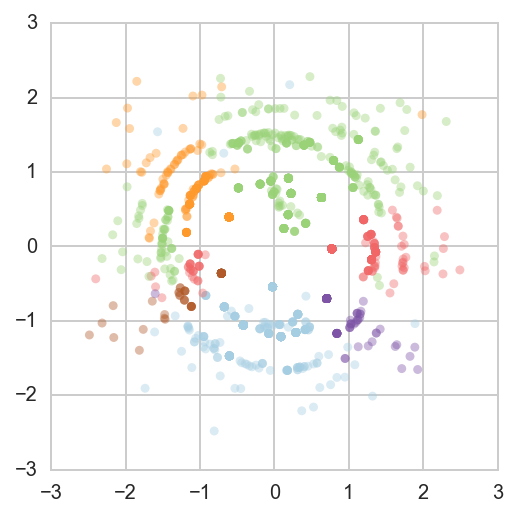

In [180]:
fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(mds_coords[:,0], mds_coords[:,1], lw=0, alpha=0.4, color=plt.cm.Paired(clusters/5))

Clusters do not corespond to concentric circles

In [181]:
def norm(x,y): return np.sqrt(x ** 2 + y ** 2)

In [182]:
distances = np.fromiter(map(norm, *mds_coords.T), dtype=np.float64)

(-1.5, 1.5)

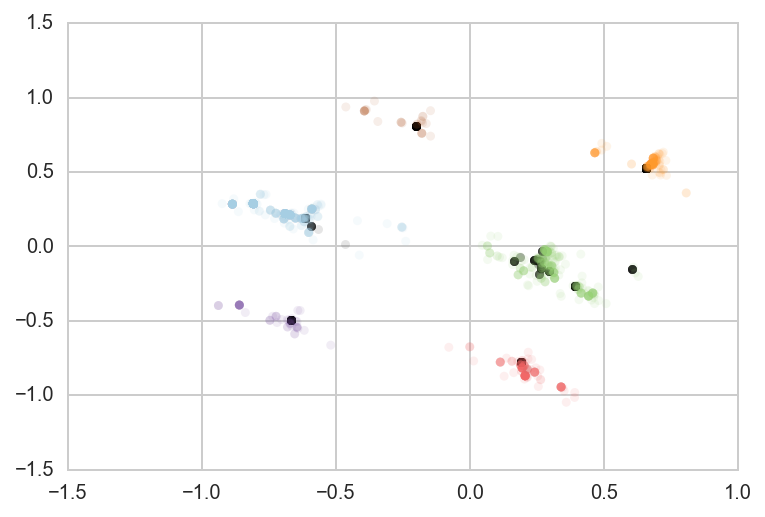

In [184]:
fig, ax = plt.subplots()

thresh = 1

ax.scatter(components[:,0][distances < thresh],
           components[:,1][distances < thresh],
           lw=0, alpha=0.1, color='k')

ax.scatter(components[:,0][distances >= thresh],
           components[:,1][distances >= thresh],
           lw=0, alpha=0.1, color=plt.cm.Paired(clusters[distances >= thresh]/5))

ax.set_xlim(-1.5,1.0)
ax.set_ylim(-1.5,1.5)

Could circles represent number of terms in descriptor?

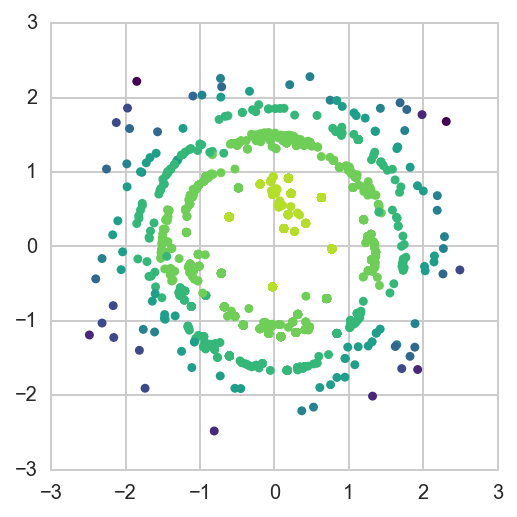

In [199]:
n_terms = list(map(len,subset))
colors = n_terms / np.max(n_terms)

fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(mds_coords[:,0], mds_coords[:,1], lw=0, color=plt.cm.viridis_r(colors))

Yes! The concentric circles correspond to the number of genre descriptor terms. We knew this varied across samples, didn't expect it to show up in the MDS.

Visualize PCA results with similar coloring

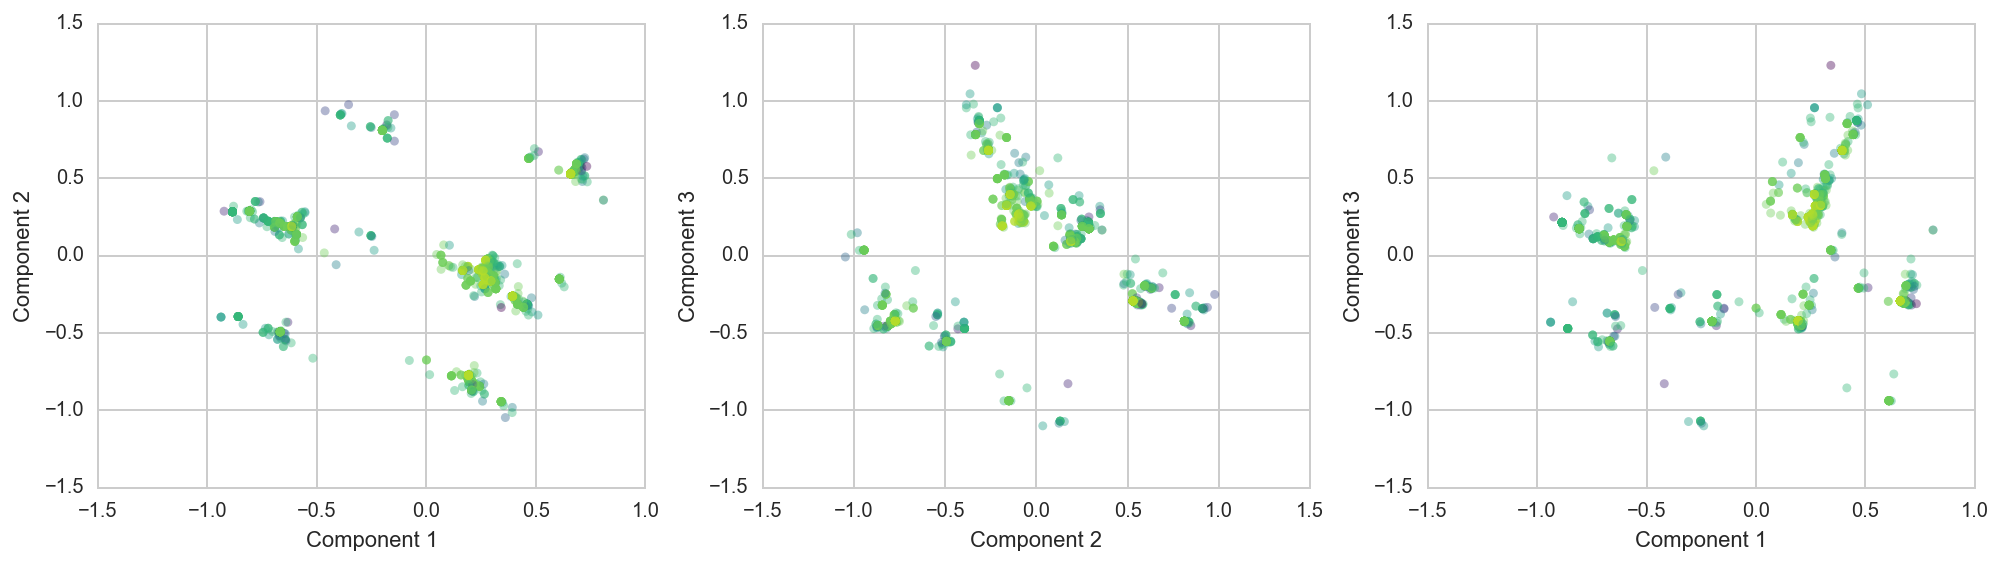

In [209]:
n_terms = list(map(len,subset))
colors = n_terms / np.max(n_terms)

fig, ax = plt.subplots(1,3,figsize=(14,4))
for i, (j, k) in enumerate([(0,1), (1,2), (0,2)]):
    ax[i].scatter(components[:,j], components[:,k], alpha=0.4, lw=0, color=plt.cm.viridis_r(colors))
    ax[i].set_xlabel('Component %d' % (j+1))
    ax[i].set_ylabel('Component %d' % (k+1))
    
fig.tight_layout()

It looks like first 3 components of PCA do not take into account number of genre terms.

Identified clusters in other PCA component visualizations

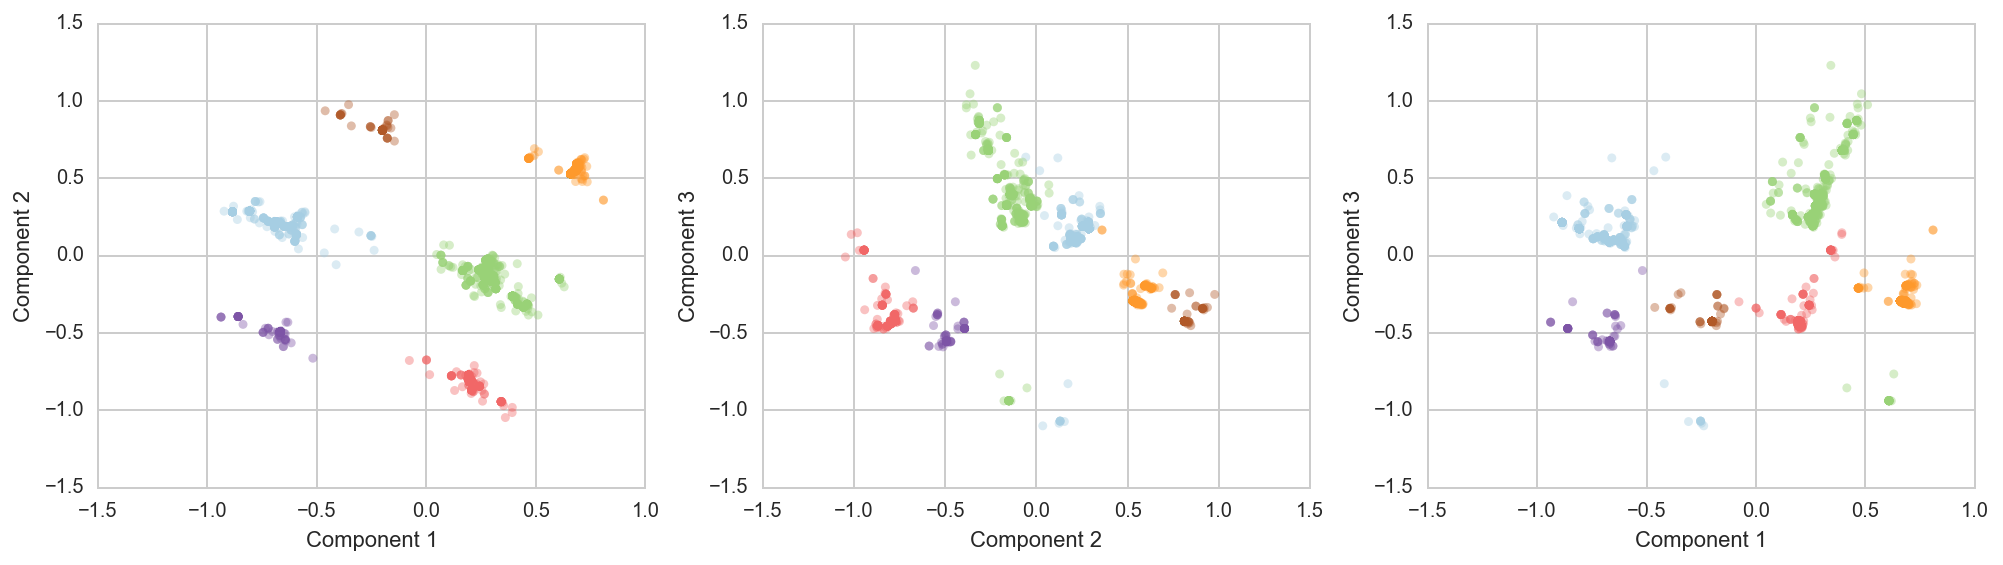

In [211]:
fig, ax = plt.subplots(1,3,figsize=(14,4))
for i, (j, k) in enumerate([(0,1), (1,2), (0,2)]):
    ax[i].scatter(components[:,j], components[:,k], alpha=0.4, lw=0, color=plt.cm.Paired(clusters/5))
    ax[i].set_xlabel('Component %d' % (j+1))
    ax[i].set_ylabel('Component %d' % (k+1))
    
fig.tight_layout()

Now we can see the most common genre terms.

In [ ]:
genre_terms.head(30)

From here we can pick out the top most common metal genre descriptors. We'll omit terms like `Metal`, `Rock`, `Heavy`, and `Hard` that aren't too helpful in narrowing down genres. This does require manual inspection, but the top descriptors are what we would expect. Let's take the top 20 terms and store them for later.

In [ ]:
top_terms = ['Death', 'Black', 'Thrash', 'Melodic', 'Doom',
             'Progressive', 'Power', 'Grindcore', 'Groove', 'Gothic',
             'Brutal', 'Metalcore', 'Sludge', 'Stoner', 'Symphonic',
             'Speed', 'Folk', 'Technical', 'Atmospheric', 'Ambient']

In [ ]:
def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 0%%, %d%%)" % np.random.randint(60, 100)

In [ ]:
wordcloud = WordCloud(width=1920,height=1080,random_state=2,
                      font_path='/usr/share/fonts/TTF/Monaco_Linux.ttf',
                      margin=20).generate(' '.join(all_terms))

fig, ax = plt.subplots(figsize=(19.2,10.8),dpi=220)
ax.imshow(wordcloud.recolor(color_func=grey_color_func))
ax.set_axis_off()

#### Generating a network using `networkx`

We want a network where bands are the nodes and the edges connect bands with overlapping genre terms.

Potential overlap metrics:

* Any overlapping terms (0 = no, 1 = yes)
* Intersection score = n of shared unique terms / total or average n combined unique terms

In [ ]:
@functools.lru_cache(maxsize=None)
def find_intersection(first, second):
    """Calculates intersection score for two given lists/tuples of words `first` and `second`."""
    intersection = set(first) & set(second)
    intersection_length = len(intersection)
    word_count = len(first) + len(second)
    if word_count == 0:
        return 0
    else:
        return (intersection_length / word_count)

def find_all_intersections(first, seconds):
    """Calculates he intersection score between `first` and all elements in `seconds`."""
    intersections = np.zeros(len(seconds))
    #func_wrapper = lambda second: find_intersection(first, second)
    #intersections = np.fromiter(map(func_wrapper, seconds), dtype=np.float64)
    for i, second in enumerate(seconds):
        intersections[i] = find_intersection(first, second)
    return intersections
    
def get_pairs(x, y):
    """Returns an array containing all possible combinations of each element in `x` and `y`."""
    return np.transpose([np.repeat(x, len(y)), np.tile(y, len(x))])

In [ ]:
%%timeit
int_scores = data['GenreTerms'][:1].map(lambda first: find_all_intersections(first, data['GenreTerms'].values))

In [ ]:
int_scores

In [ ]:
np.fromiter(map(len, data['GenreTerms'].values[:5]), dtype=np.float64)

In [ ]:
find_per_entry_intersections = lambda first: find_all_intersections(first, data['GenreTerms'].values)
data['GenreIntScores'] = data['GenreTerms'][:100].map(find_per_entry_intersections)

In [ ]:
286 * len(data['GenreTerms']) / 1000 / 1000 / 60

In [ ]:
%%timeit
x = data['GenreTerms'].values[:1]
y = data['GenreTerms'].values
pairs = get_pairs(x, y)
int_scores = np.apply_along_axis(lambda pair: find_intersection(pair[0], pair[1]), 1, pairs)

In [ ]:
int_scores

In [ ]:
data['GenreTerms'][20:30].map(lambda x: find_intersection(x, data['GenreTerms'].values[0]))

## Analysis

Revisit questions [here](#Specific-Questions)

### Bands by country

Most popular genre in each of the top countries.

In [ ]:
top_countries = [country for country in counts_by_country[:20].index]

In [ ]:
top_countries

In [ ]:
def get_country_subset(data, country):
    return data[data['Country'] == country]

def get_genre_subset(data, genre_term):
    return data[data['Genre'].str.contains(genre_term)]

def get_country_genre_subset(data, country, genre_term):
    country_subset = get_country_subset(data, country)
    genre_subset = get_genre_subset(country_subset, genre_term)
    return genre_subset

In [ ]:
def get_country_genre_subset(data, country, genre_term):
    country_mask = data['Country'] == country
    country_subset = data[country_mask]
    genre_mask = country_subset['Genre'].str.contains(genre_term)
    genre_subset = country_subset[genre_mask]
    return genre_subset

In [ ]:
country_mask = data['Country'] == 'Sweden'
country_subset = data[country_mask]
genre_mask = country_subset['Genre'].str.contains('Death')
genre_subset = country_subset[genre_mask]

genre_subset['BandName'].count()

In [ ]:
country = 'Germany'
subset = data[data['Country'] == country]
total_bands = len(subset)
term_counts = [len(subset[subset['Genre'].str.contains(term)]) for term in top_terms]
term_pct = np.array(term_counts) / total_bands * 100

x = np.arange(len(term_counts))
width = 0.5
fig, ax = plt.subplots()
ax.bar(x, term_pct, width=width, align='center', color=plt.cm.Paired(x / x.max()))
ax.set_xticks(x)
ax.set_xticklabels(top_terms, rotation=90)
ax.set_xlim(-width, 20-width)
ax.set_xlabel('Genre term')
ax.set_ylabel('% of bands with genre term')
ax.set_title(country)

In [ ]:
sum(term_pct)

### Number of bands by country

Top 20 and bottom 20.

In [ ]:
counts_by_country = data.groupby('Country')['BandName'].count()
counts_by_country.sort_values(ascending=False, inplace=True);

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
counts_by_country[:20].plot(kind='bar', ax=ax[0], color='steelblue', lw=0)
counts_by_country[-20:].plot(kind='bar', ax=ax[1], color='coral', lw=0)
ax[1].set_ylim(0, 5)